In [1]:
!pip install transformers datasets wandb

In [2]:
!pip install tiktoken

In [3]:
!pip install ipywidgets




In [4]:

!pip install sentencepiece transformers --upgrade




   ---------------------------------------- 0.0/10.4 MB ? eta -:--:--
   ------------------- -------------------- 5.0/10.4 MB 37.7 MB/s eta 0:00:01
   ---------------------------------------- 10.4/10.4 MB 40.4 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.51.1
    Uninstalling transformers-4.51.1:
      Successfully uninstalled transformers-4.51.1


In [5]:
# 1. Initialize environment and imports correctly
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'  # Enable synchronous CUDA errors

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForMaskedLM, DistilBertForMaskedLM, AlbertTokenizer, AutoConfig
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup
from datasets import load_dataset
import numpy as np
from tqdm import tqdm
import logging
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from contextlib import nullcontext
import pandas as pd
from torch.cuda.amp import GradScaler


In [6]:
# Set up logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler("training.log"),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger(__name__)


In [7]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'  # Ensure synchronous error reporting
import torch

class Config:
    def __init__(self):
        # Model parameters
        self.teacher_model_name = "ai4bharat/indic-bert"
        self.student_model_name = "distilbert-base-multilingual-cased"
        self.max_length = 64
        self.batch_size = 16
        self.learning_rate = 5e-5
        self.weight_decay = 0.01
        self.teacher_epochs = 3
        self.distillation_epochs = 5
        self.warmup_steps = 1000
        self.gradient_accumulation_steps = 4
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Device configuration
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Language parameters
        self.teacher_lang = "hi"  # Hindi
        self.student_lang = "hne"  # Chhattisgarhi

        # RL parameters - optimized after research
        self.gamma = 0.99  # Discount factor
        self.entropy_coef = 0.01  # Entropy coefficient for exploration
        self.rl_lr = 2e-5  # Learning rate for RL
        self.teacher_weight = 0.5  # Weight for teacher model influence
        self.few_shot_examples = 5  # Number of examples for few-shot prompting

        # Dataset
        self.train_test_split = 0.1

        # Paths
        self.output_dir = "output/"
        self.log_dir = "logs/"
        self.model_dir = "models/"

        # Evaluation
        self.eval_every = 100  # Evaluate every N batches
        self.save_every = 500  # Save model every N batches
        self.early_stopping_patience = 3
        
        # Create directories
        os.makedirs(self.output_dir, exist_ok=True)
        os.makedirs(self.log_dir, exist_ok=True)
        os.makedirs(self.model_dir, exist_ok=True)


In [8]:
from transformers import AutoConfig, AutoModelForMaskedLM

class TeacherModel(nn.Module):
    def __init__(self, model_name, tokenizer_vocab_size=None):
        super().__init__()
        # Load config first
        self.config = AutoConfig.from_pretrained(model_name)
        original_vocab_size = self.config.vocab_size
        logger.info(f"Original model vocab size: {original_vocab_size}")
        
        # Initialize model on CPU with float32
        self.bert_model = AutoModelForMaskedLM.from_pretrained(
            model_name,
            config=self.config,
            torch_dtype=torch.float32  # Force FP32 initialization
        )
        
        # Resize embeddings if needed BEFORE moving to GPU
        if tokenizer_vocab_size and tokenizer_vocab_size != self.config.vocab_size:
            logger.info(f"Resizing embeddings from {self.config.vocab_size} to {tokenizer_vocab_size}")
            self._safe_resize_embeddings(tokenizer_vocab_size)
            
            # Verify resize was successful
            if self.bert_model.config.vocab_size != tokenizer_vocab_size:
                logger.error(f"Resize failed! Current size: {self.bert_model.config.vocab_size}")
                raise ValueError("Embedding resize operation failed")
        
        # Initialize adapter layer with verified vocab size
        self.hidden_size = self.config.hidden_size
        self.vocab_size = self.bert_model.config.vocab_size
        self.next_token_adapter = nn.Linear(self.hidden_size, self.vocab_size)
        logger.info(f"TeacherModel initialized with vocab_size={self.vocab_size}")
    
    def _safe_resize_embeddings(self, new_vocab_size):
        """Improved embedding resize with better validation"""
        old_embeddings = self.bert_model.get_input_embeddings()
        old_size = old_embeddings.num_embeddings
        
        # Skip if new size is smaller (would truncate vocabulary)
        if new_vocab_size <= old_size:
            logger.warning(f"New vocab size {new_vocab_size} <= current size {old_size}. Skipping resize.")
            return
        
        # Perform resize
        new_embeddings = self.bert_model.resize_token_embeddings(new_vocab_size)
        
        # Initialize new embedding weights with normal distribution
        if new_vocab_size > old_size:
            with torch.no_grad():
                # Calculate statistics of existing embeddings for initialization
                mean = old_embeddings.weight.data.mean().item()
                std = old_embeddings.weight.data.std().item()
                
                # Initialize new tokens with appropriate distribution
                new_embeddings.weight.data[old_size:] = torch.normal(
                    mean=mean, std=std,
                    size=(new_vocab_size - old_size, self.config.hidden_size)
                )
        
        # Update all necessary config values
        self.bert_model.config.vocab_size = new_vocab_size
        self.config.vocab_size = new_vocab_size
        logger.info(f"Embeddings successfully resized to {new_vocab_size}")


    def forward(self, input_ids, attention_mask=None):
        # Validate input tensor indices
        if torch.min(input_ids) < 0 or torch.max(input_ids) >= self.vocab_size:
            min_id = torch.min(input_ids).item()
            max_id = torch.max(input_ids).item()
            logger.error(f"Invalid input_ids detected! Range: [{min_id}, {max_id}], Vocab size: {self.vocab_size}")
            raise ValueError(f"Input IDs must be within range [0, {self.vocab_size-1}]")
        
        # Create token_type_ids tensor (required for Albert models)
        batch_size, seq_length = input_ids.shape
        token_type_ids = torch.zeros(batch_size, seq_length, 
                                   dtype=torch.long, device=input_ids.device)
        
        # Use try/except to catch any forward pass errors
        try:
            with torch.amp.autocast(device_type=input_ids.device.type):
                outputs = self.bert_model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    token_type_ids=token_type_ids,
                    output_hidden_states=True
                )
                
                last_hidden_state = outputs.hidden_states[-1]
                return self.next_token_adapter(last_hidden_state)
        except Exception as e:
            logger.error(f"Error in forward pass: {e}")
            raise


In [9]:
class StudentModel(nn.Module):
    def __init__(self, model_name):
        super(StudentModel, self).__init__()
        # Use DistilBERT as the base model
        self.model = DistilBertForMaskedLM.from_pretrained(model_name)
        
        # Add a next token prediction head
        self.vocab_size = self.model.config.vocab_size
        self.hidden_size = self.model.config.dim
        self.next_token_head = nn.Linear(self.hidden_size, self.vocab_size)
        
    def forward(self, input_ids, attention_mask=None):
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask, output_hidden_states=True)
        hidden_states = outputs.hidden_states[-1]
        logits = self.next_token_head(hidden_states)
        return logits
    
    # Method for RL action and value calculation
    def get_action_and_value(self, input_ids, attention_mask=None):
        # Get logits for the entire sequence
        logits = self.forward(input_ids, attention_mask)
        
        # Extract only the last token position logits for next token prediction
        last_token_logits = logits[:, -1, :]
        
        # Get probabilities
        probs = torch.softmax(last_token_logits, dim=-1)
        
        # Sample from the distribution
        dist = torch.distributions.Categorical(probs)
        action = dist.sample()  # Shape: [batch_size]
        
        # Get log probability of the action
        log_prob = dist.log_prob(action)  # Shape: [batch_size]
        
        # Calculate entropy for exploration encouragement
        entropy = dist.entropy().mean()  # Scalar
        
        return action, log_prob, entropy, probs


In [10]:
# Cell 8: DataProcessor (Refined Pad Token and Vocab Size Logging)
class DataProcessor:
    def __init__(self, config):
        self.config = config
        
        # Load tokenizer first
        self._load_tokenizers()
        
        # Verify embedding compatibility
        self._verify_embedding_sizes()

    def _load_tokenizers(self):
        # Teacher tokenizer with AlbertTokenizer
        self.teacher_tokenizer = AlbertTokenizer.from_pretrained(
            self.config.teacher_model_name,
            keep_accents=True
        )
        
        # Add [PAD] token if missing
        if self.teacher_tokenizer.pad_token is None:
            self.teacher_tokenizer.add_special_tokens({'pad_token': '[PAD]'})
            
        self.teacher_pad_id = self.teacher_tokenizer.pad_token_id
        self.teacher_vocab_size = len(self.teacher_tokenizer)

        # Student tokenizer (DistilBERT)
        self.student_tokenizer = AutoTokenizer.from_pretrained(
            self.config.student_model_name
        )

    def _verify_embedding_sizes(self):
        """Ensure tokenizer and model vocab sizes match before model creation"""
        teacher_config = AutoConfig.from_pretrained(self.config.teacher_model_name)
        if teacher_config.vocab_size != self.teacher_vocab_size:
            logger.warning(f"Tokenizer vocab ({self.teacher_vocab_size}) ≠ model vocab ({teacher_config.vocab_size})")
    def load_dataset(self):
        # ... (Keep trust_remote_code=True) ...
        try:
            logger.info("Loading NLLB dataset for Hindi-Chhattisgarhi pair")
            nllb_dataset = load_dataset("allenai/nllb", "hin_Deva-hne_Deva", trust_remote_code=True)
            hindi_samples = [{"lang": self.config.teacher_lang, "text": item['translation']['hin_Deva']} for item in nllb_dataset["train"]]
            chhattisgarhi_samples = [{"lang": self.config.student_lang, "text": item['translation']['hne_Deva']} for item in nllb_dataset["train"]]
            logger.info(f"Loaded {len(hindi_samples)} Hindi, {len(chhattisgarhi_samples)} Chhattisgarhi samples")
            return hindi_samples, chhattisgarhi_samples
        except Exception as e:
            logger.error(f"Error loading dataset: {e}", exc_info=True) # Log traceback
            raise


In [11]:
# Assume this function is defined in a previous cell (e.g., Cell 225) or at the top of Cell 233
import numpy as np
from tqdm import tqdm # Make sure tqdm is imported

def validate_dataset(dataset, tokenizer, name="dataset", sample_size=None):
    """Ensure all token IDs in the dataset are valid against the tokenizer's vocab size."""
    vocab_size = len(tokenizer)
    logger.info(f"Validating {name} (Tokenizer Vocab Size: {vocab_size})...")

    num_samples_to_check = len(dataset) if sample_size is None else min(sample_size, len(dataset))
    indices_to_check = range(num_samples_to_check) if sample_size is None else np.random.choice(len(dataset), num_samples_to_check, replace=False)
    logger.info(f"Checking {num_samples_to_check} samples.")

    invalid_count = 0
    first_invalid_idx = -1
    first_invalid_ids = None

    for i in tqdm(indices_to_check, desc=f"Validating {name}"):
        try:
            sample = dataset[i]
            # Ensure 'input_ids' exists and is a tensor
            if 'input_ids' not in sample or not isinstance(sample['input_ids'], torch.Tensor):
                 logger.warning(f"Sample {i} in {name} is missing 'input_ids' tensor. Skipping.")
                 invalid_count +=1 # Count as invalid if structure is wrong
                 if first_invalid_idx == -1: first_invalid_idx = i
                 continue

            input_ids = sample['input_ids']

            # Check for invalid IDs (negative or >= vocab_size)
            min_id_val = torch.min(input_ids).item()
            max_id_val = torch.max(input_ids).item()

            if min_id_val < 0 or max_id_val >= vocab_size:
                invalid_count += 1
                if first_invalid_idx == -1: # Log first error in detail
                    first_invalid_idx = i
                    first_invalid_ids = input_ids.tolist() # Get the problematic IDs
                    logger.error(f"!!! Invalid token ID found in {name} at index {i} !!!")
                    logger.error(f"    Range Found: [{min_id_val}, {max_id_val}], Required Range: [0, {vocab_size-1}]")
                    logger.error(f"    Problematic IDs (sample): {first_invalid_ids[:20]}...") # Show beginning of IDs
                    # Try decoding for context
                    try:
                        # Filter out only potentially valid IDs for decoding attempt
                        valid_range_ids = [id_val for id_val in first_invalid_ids if 0 <= id_val < vocab_size]
                        if valid_range_ids:
                             decoded = tokenizer.decode(valid_range_ids, skip_special_tokens=False)
                             logger.error(f"    Partial Decode Attempt of valid-range IDs: '{decoded}'")
                        else:
                             logger.error(f"    Cannot decode, no IDs were within the valid range [0, {vocab_size-1}]")
                    except Exception as decode_e:
                        logger.error(f"    Could not decode IDs: {decode_e}")

        except IndexError:
            logger.error(f"IndexError accessing sample {i} in {name}. Dataset length reported as {len(dataset)}.")
            invalid_count += 1
            if first_invalid_idx == -1: first_invalid_idx = i
        except Exception as e:
            logger.error(f"Unexpected error processing item at index {i} in {name}: {e}", exc_info=True)
            invalid_count += 1 # Count other errors as invalid
            if first_invalid_idx == -1: first_invalid_idx = i

    if invalid_count > 0:
        logger.error(f"Validation FAILED for {name}. Found {invalid_count} invalid samples out of {num_samples_to_check} checked.")
        logger.error(f"First invalid sample detected at index: {first_invalid_idx}")
        return False
    else:
        logger.info(f"Dataset {name} validation passed ({num_samples_to_check} samples checked).")
        return True


In [12]:
# Cell 9: NextWordPredictionDataset (Add check for pad token ID)
class NextWordPredictionDataset(Dataset):
    def __init__(self, samples, tokenizer, max_length=128):
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.pad_token_id = tokenizer.pad_token_id
        self.vocab_size = len(tokenizer) # Store vocab size

        if self.pad_token_id is None:
             logger.error(f"CRITICAL: Tokenizer {tokenizer.name_or_path} provided to dataset without a valid pad_token_id!")
             # Attempt recovery or raise error earlier? For now, use default 0.
             self.pad_token_id = 0

        self.examples = [s["text"] for s in samples if isinstance(s.get("text"), str) and len(s["text"]) > 10]
        if len(self.examples) < len(samples):
             logger.warning(f"Filtered out {len(samples) - len(self.examples)} samples due to length or type.")
        logger.info(f"Created dataset with {len(self.examples)} examples")

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, idx):
        if idx >= len(self.examples):
            raise IndexError(f"Index {idx} out of bounds")

        text = self.examples[idx]
        try:
            encoding = self.tokenizer(
                text,
                max_length=self.max_length,
                padding="max_length",
                truncation=True,
                return_tensors="pt"
            )
            input_ids = encoding["input_ids"].squeeze(0) # Remove batch dim
            attention_mask = encoding["attention_mask"].squeeze(0)

            # Check for invalid IDs immediately after tokenization
            if torch.any(input_ids >= self.vocab_size) or torch.any(input_ids < 0):
                 logger.error(f"Invalid IDs found *during tokenization* for index {idx}, text: '{text[:100]}...'")
                 logger.error(f"Min: {torch.min(input_ids)}, Max: {torch.max(input_ids)}, Vocab Size: {self.vocab_size}")
                 # Replace invalid IDs with UNK token ID? Or skip sample? Skipping is safer.
                 # For now, let's just log and proceed, the check in train_teacher will catch it.
                 # Or raise an error here:
                 # raise ValueError("Invalid token IDs generated by tokenizer.")

            # Handle empty/short sequences after tokenization/padding
            if input_ids.numel() <= 1:
                bos = self.tokenizer.cls_token_id if self.tokenizer.cls_token_id is not None else self.tokenizer.bos_token_id
                eos = self.tokenizer.sep_token_id if self.tokenizer.sep_token_id is not None else self.tokenizer.eos_token_id
                bos = bos if bos is not None else self.pad_token_id
                eos = eos if eos is not None else self.pad_token_id
                input_ids = torch.tensor([bos] + [self.pad_token_id] * (self.max_length - 1), dtype=torch.long)
                attention_mask = torch.tensor([1] + [0] * (self.max_length - 1), dtype=torch.long)
                logger.warning(f"Handling short/empty sequence for index {idx}")

            # Create labels (shifted input_ids)
            labels = input_ids.clone()
            # Shift - use pad_token_id for positions where we don't predict
            labels[:-1] = input_ids[1:]
            labels[-1] = self.pad_token_id # No label for the last token prediction

            # Input should be sequence up to second-to-last token
            model_input_ids = input_ids[:-1]
            model_attention_mask = attention_mask[:-1]
            model_labels = labels[:-1] # Labels correspond to model_input_ids positions

            return {
                "input_ids": model_input_ids,
                "attention_mask": model_attention_mask,
                "labels": model_labels
            }
        except Exception as e:
            logger.error(f"Error processing item at index {idx}, text: '{text[:100]}...': {e}", exc_info=True)
            # Return a dummy item or skip? Returning dummy might hide errors.
            # Let's create a fully padded dummy item.
            pad_id = self.pad_token_id
            dummy_input_ids = torch.full((self.max_length - 1,), pad_id, dtype=torch.long)
            dummy_attn_mask = torch.zeros((self.max_length - 1,), dtype=torch.long)
            dummy_labels = torch.full((self.max_length - 1,), pad_id, dtype=torch.long)
            return {"input_ids": dummy_input_ids, "attention_mask": dummy_attn_mask, "labels": dummy_labels}




In [13]:
class FewShotDataset(Dataset):
    def __init__(self, samples, tokenizer, few_shot_examples=5, max_length=128):
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.few_shot_examples = few_shot_examples
        
        # Ensure pad token is set
        if self.tokenizer.pad_token is None and hasattr(self.tokenizer, 'eos_token'):
            self.tokenizer.pad_token = self.tokenizer.eos_token
        
        # Process samples
        self.examples = []
        self.few_shot_pool = []
        
        # Select few-shot examples
        valid_samples = [s for s in samples if len(s["text"]) > 10]
        if len(valid_samples) > few_shot_examples:
            self.few_shot_pool = valid_samples[:few_shot_examples]
            self.examples = valid_samples[few_shot_examples:]
        else:
            self.examples = valid_samples
            
        logger.info(f"Created few-shot dataset with {len(self.examples)} examples and {len(self.few_shot_pool)} few-shot examples")
    
    def __len__(self):
        return len(self.examples)
    
    def __getitem__(self, idx):
        if idx >= len(self.examples):
            raise IndexError(f"Index {idx} out of bounds for dataset with {len(self.examples)} examples")
        
        # Get the target example
        target_text = self.examples[idx]["text"]
        
        # Build few-shot context with examples and their completions
        few_shot_context = ""
        for example in self.few_shot_pool:
            # Split text to simulate next word prediction
            words = example["text"].split()
            if len(words) > 1:
                prefix = " ".join(words[:-1])
                target = words[-1]
                few_shot_context += f"Text: {prefix}\nNext word: {target}\n\n"
        
        # Add the target without completion
        target_words = target_text.split()
        if len(target_words) > 1:
            prefix = " ".join(target_words[:-1])
            target = target_words[-1]
            few_shot_context += f"Text: {prefix}\nNext word:"
            
            # Tokenize few-shot context
            context_encoding = self.tokenizer(few_shot_context, max_length=self.max_length, 
                                            padding="max_length", truncation=True, return_tensors="pt")
            
            # Tokenize target (the expected next word)
            target_encoding = self.tokenizer(target, return_tensors="pt")
            
            # Ensure we have valid tensors
            input_ids = context_encoding["input_ids"].squeeze()
            attention_mask = context_encoding["attention_mask"].squeeze()
            target_id = target_encoding["input_ids"].squeeze()[0]  # Just take the first token
            
            return {
                "input_ids": input_ids,
                "attention_mask": attention_mask,
                "labels": target_id
            }
        else:
            # Handle edge case of single word
            return self.__getitem__((idx + 1) % len(self))


In [14]:
def compute_reward(teacher_probs, student_action, target_tokens, alpha=0.7):
    """Improved reward function with better learning signals"""
    batch_size = teacher_probs.shape[0]
    reward = torch.zeros(batch_size, device=teacher_probs.device)
    
    for i in range(batch_size):
        # Higher reward for matching the target
        if student_action[i].item() == target_tokens[i].item():
            reward[i] += 5.0
        else:
            # Small penalty for wrong answers to speed up learning
            reward[i] -= 0.1
        
        # Add partial reward for being close (teacher had high probability for the correct token)
        if target_tokens[i].item() < teacher_probs.shape[1]:
            teacher_confidence_for_correct = teacher_probs[i, target_tokens[i].item()]
            reward[i] += alpha * teacher_confidence_for_correct
        
        # Add smaller reward based on teacher probability of student's action
        token_idx = student_action[i].item()
        if token_idx < teacher_probs.shape[1]:
            teacher_confidence = teacher_probs[i, token_idx]
            reward[i] += (alpha * 0.5) * teacher_confidence
    
    return reward


In [45]:
# Cell 228: train_teacher (Fix attribute name for pad_token_id)
from torch.cuda.amp import GradScaler
import numpy as np # Ensure numpy is imported if not already

def train_teacher(model, train_loader, val_loader, config, data_processor): # Added data_processor
    logger.info("Starting teacher model fine-tuning for Hindi...")
    model.to(config.device)
    optimizer = AdamW(model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)
    # Adjust total_steps for gradient accumulation
    num_update_steps_per_epoch = len(train_loader) // config.gradient_accumulation_steps if len(train_loader) > 0 else 0
    total_steps = num_update_steps_per_epoch * config.teacher_epochs
    num_warmup_steps = min(config.warmup_steps, total_steps // 10) if total_steps > 0 else 0
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=max(1, total_steps))

    # Use torch.amp.GradScaler with device type
    # Corrected GradScaler call
    scaler = GradScaler(enabled=(config.device.type == 'cuda'))

    # *** FIX: Use the correct attribute name from data_processor ***
    pad_token_id = data_processor.teacher_pad_id
    # Use vocab size directly from the model's config for checking IDs
    teacher_vocab_size = model.config.vocab_size

    if pad_token_id is None:
        logger.error("CRITICAL: Teacher pad_token_id is None. Loss calculation will be incorrect.")
        # Assign -100 which is standard practice for ignoring index in CrossEntropyLoss
        pad_token_id = -100
        logger.info(f"Using ignore_index={pad_token_id} for teacher loss.")
    # Always define loss_fn outside the loop
    loss_fn = nn.CrossEntropyLoss(ignore_index=pad_token_id)

    best_loss = float('inf')
    early_stopping_counter = 0
    global_step = 0

    for epoch in range(config.teacher_epochs):
        model.train()
        epoch_loss = 0.0
        optimizer.zero_grad() # Zero gradients at the start of each epoch/accumulation cycle

        for batch_idx, batch in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{config.teacher_epochs}")):
            try:
                input_ids = batch["input_ids"].to(config.device)
                attention_mask = batch["attention_mask"].to(config.device)
                labels = batch["labels"].to(config.device)

                # <<< START INPUT VALIDATION >>>
                min_id, max_id = torch.min(input_ids), torch.max(input_ids)
                if max_id >= teacher_vocab_size or min_id < 0:
                    logger.error(f"!!!!! Invalid input_ids detected in batch {batch_idx+1} !!!!!")
                    logger.error(f"Shape: {input_ids.shape}, Min: {min_id.item()}, Max: {max_id.item()}, VocabSize: {teacher_vocab_size}")
                    invalid_mask = (input_ids < 0) | (input_ids >= teacher_vocab_size)
                    logger.error(f"Problematic IDs: {input_ids[invalid_mask]}")
                    # Attempt to decode the first sequence containing an invalid ID
                    try:
                        first_invalid_row_idx = torch.where(invalid_mask.any(dim=1))[0][0].item()
                        # Use original batch data from CPU for decoding
                        problem_ids_cpu = batch["input_ids"][first_invalid_row_idx].tolist()
                        decoded = data_processor.teacher_tokenizer.decode(problem_ids_cpu, skip_special_tokens=False)
                        logger.error(f"Decoded sequence (row {first_invalid_row_idx}): {decoded}")
                        logger.error(f"Sequence IDs: {problem_ids_cpu}")
                    except Exception as decode_e:
                        logger.error(f"Could not decode sequence: {decode_e}")
                    # Skip this batch
                    logger.warning("Skipping batch due to invalid input IDs.")
                    # Clear gradients if we were in the middle of accumulation
                    if (batch_idx + 1) % config.gradient_accumulation_steps != 0: # If not the first micro-batch of cycle
                        optimizer.zero_grad()
                    continue
                # <<< END INPUT VALIDATION >>>

                # Check labels too (optional but good practice)
                min_lbl, max_lbl = torch.min(labels), torch.max(labels)
                # Allow pad_token_id in labels, but no other invalid IDs
                if max_lbl >= teacher_vocab_size or (min_lbl < 0 and min_lbl != pad_token_id):
                    logger.error(f"!!!!! Invalid labels detected in batch {batch_idx+1} !!!!!")
                    logger.error(f"Shape: {labels.shape}, Min: {min_lbl.item()}, Max: {max_lbl.item()}, VocabSize: {teacher_vocab_size}, PadID: {pad_token_id}")
                    # Log details similar to input_ids if needed
                    logger.warning("Skipping batch due to invalid label IDs.")
                    if (batch_idx + 1) % config.gradient_accumulation_steps != 0:
                        optimizer.zero_grad()
                    continue

                # Use autocast context manager correctly
                context = torch.amp.autocast(device_type=config.device.type, dtype=torch.float16, enabled=(config.device.type == 'cuda'))
                with context:
                    logits = model(input_ids, attention_mask)
                    loss = loss_fn(logits.view(-1, teacher_vocab_size), labels.view(-1))
                    # Check loss value before scaling
                    if torch.isnan(loss) or torch.isinf(loss):
                         logger.error(f"NaN or Inf loss detected *before* scaling at Epoch {epoch+1}, Batch {batch_idx+1}! Skipping step.")
                         # Reset scaler state and skip optimizer step for this accumulation cycle
                         scaler = GradScaler(init_scale=scaler.get_scale() / 2.0, enabled=(config.device.type == 'cuda')) # Reduce scale
                         optimizer.zero_grad() # Zero grad for this cycle
                         continue # Skip backward and step

                    loss = loss / config.gradient_accumulation_steps # Scale loss for accumulation

                # Scaler operations outside the autocast context
                scaler.scale(loss).backward()

                if (batch_idx + 1) % config.gradient_accumulation_steps == 0:
                    # Unscale, clip, step, update
                    scaler.unscale_(optimizer)
                    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                    scaler.step(optimizer)
                    scale_before_update = scaler.get_scale()
                    scaler.update()
                    scale_after_update = scaler.get_scale()
                    optimizer.zero_grad() # Zero grad after successful step
                    scheduler.step()
                    global_step += 1

                    # Log scale changes if scale was skipped/reduced
                    if scale_after_update < scale_before_update:
                        logger.warning(f"Scaler skipped step or reduced scale to {scale_after_update} at step {global_step}")


                epoch_loss += loss.item() * config.gradient_accumulation_steps # Accumulate unscaled loss for logging

                if (batch_idx + 1) % 50 == 0: # Log every 50 micro-batches
                    logger.info(f"Epoch {epoch+1}, Batch {batch_idx+1}/{len(train_loader)}, Step Loss: {loss.item() * config.gradient_accumulation_steps:.4f}, Scale: {scaler.get_scale()}") # Log unscaled step loss

            except RuntimeError as e:
                 if "CUDA out of memory" in str(e):
                     logger.error(f"CUDA OOM error during training batch {batch_idx+1}. Attempting to recover...")
                     if config.device.type == 'cuda': torch.cuda.empty_cache()
                     optimizer.zero_grad() # Clear potentially bad gradients
                     # Try reducing batch size dynamically? For now, just log and skip batch
                     logger.warning("Skipping batch due to OOM.")
                     continue
                 else:
                     logger.error(f"RuntimeError during training batch {batch_idx+1}: {e}", exc_info=True)
                     if config.device.type == 'cuda': torch.cuda.empty_cache()
                     optimizer.zero_grad()
                     continue # Skip batch on other runtime errors

            except Exception as e:
                logger.error(f"Error during training batch {batch_idx+1}: {e}", exc_info=True)
                # Attempt to clear memory and potentially skip
                if config.device.type == 'cuda': torch.cuda.empty_cache()
                optimizer.zero_grad() # Clear potentially bad gradients
                continue


        avg_epoch_loss = epoch_loss / (len(train_loader) // config.gradient_accumulation_steps * config.gradient_accumulation_steps) if len(train_loader) > 0 else float('nan')

        # Validation - Pass the correct pad_token_id
        val_loss, val_perplexity, val_accuracy = evaluate_teacher(model, val_loader, config, pad_token_id)

        logger.info(f"Epoch {epoch+1} completed. Avg Train Loss: {avg_epoch_loss:.4f}, Val Loss: {val_loss:.4f}, Val Perplexity: {val_perplexity:.4f}, Val Accuracy: {val_accuracy:.4f}")

        # Checkpointing and Early Stopping
        if not np.isnan(val_loss) and val_loss < best_loss:
            best_loss = val_loss
            early_stopping_counter = 0
            torch.save(model.state_dict(), os.path.join(config.model_dir, "best_teacher_model.pt"))
            logger.info(f"New best teacher model saved with val loss: {best_loss:.4f}")
        elif not np.isnan(val_loss):
            early_stopping_counter += 1
            logger.info(f"Validation loss did not improve for {early_stopping_counter} epoch(s). Best loss: {best_loss:.4f}")
            if early_stopping_counter >= config.early_stopping_patience:
                logger.info(f"Early stopping triggered after {epoch+1} epochs")
                break
        else:
            logger.warning(f"Validation loss is NaN at epoch {epoch+1}.")
            early_stopping_counter += 1 # Still count NaN as non-improving
            logger.info(f"NaN validation loss encountered. Early stopping counter: {early_stopping_counter}/{config.early_stopping_patience}")
            if early_stopping_counter >= config.early_stopping_patience:
                logger.info(f"Early stopping triggered due to persistent NaN validation loss.")
                break


    # Load best model
    best_model_path = os.path.join(config.model_dir, "best_teacher_model.pt")
    if os.path.exists(best_model_path):
        try:
            # Load state dict onto the correct device directly
            map_location = config.device
            model.load_state_dict(torch.load(best_model_path, map_location=map_location))
            logger.info(f"Loaded best teacher model weights from {best_model_path}.")
        except Exception as e:
             logger.error(f"Error loading best teacher model weights: {e}")
    else:
        logger.warning("No best teacher model checkpoint found. Returning model from last epoch.")
    return model


In [16]:
# Cell 14: evaluate_teacher (Added ignore_index and pad_token_id parameter)
def evaluate_teacher(model, val_loader, config, pad_token_id): # Added pad_token_id parameter
    model.eval()
    total_loss = 0
    all_preds = []
    all_targets = []

    # *** FIX: Define loss function with ignore_index ***
    loss_fn = nn.CrossEntropyLoss(ignore_index=pad_token_id if pad_token_id is not None else -100)

    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Evaluating Teacher"):
            input_ids = batch["input_ids"].to(config.device)
            attention_mask = batch["attention_mask"].to(config.device)
            labels = batch["labels"].to(config.device)

            with torch.amp.autocast(device_type=config.device.type, enabled=(config.device.type == 'cuda')):
                logits = model(input_ids, attention_mask)
                # Calculate loss using pre-defined function
                loss = loss_fn(logits.view(-1, model.vocab_size), labels.view(-1))

            if not torch.isnan(loss): # Only accumulate valid losses
                total_loss += loss.item()
            else:
                logger.warning("NaN loss encountered during teacher evaluation.")

            preds = torch.argmax(logits, dim=-1).cpu().numpy()
            targets = labels.cpu().numpy()

            # *** FIX: Exclude padding tokens from accuracy calculation ***
            # Create a mask for non-padding tokens in the labels
            valid_indices = (targets != pad_token_id) if pad_token_id is not None else np.ones_like(targets, dtype=bool)

            # Flatten and apply mask
            all_preds.extend(preds.flatten()[valid_indices.flatten()])
            all_targets.extend(targets.flatten()[valid_indices.flatten()])

    # Calculate metrics, checking for division by zero or empty lists
    num_batches = len(val_loader)
    num_targets = len(all_targets)

    avg_loss = total_loss / num_batches if num_batches > 0 and not np.isnan(total_loss) else float('nan')
    perplexity = np.exp(avg_loss) if not np.isnan(avg_loss) else float('nan')
    accuracy = accuracy_score(all_targets, all_preds) if num_targets > 0 else 0.0

    return avg_loss, perplexity, accuracy


In [17]:
def train_rl(teacher_model, student_model, train_loader, optimizer, scheduler, config):
    teacher_model.eval()  # Teacher model is frozen
    student_model.train()
    
    epoch_rewards = []
    epoch_losses = []
    
    # For tracking metrics
    all_predictions = []
    all_targets = []
    
    # Clear GPU cache if using CUDA
    if config.device.type == 'cuda':
        torch.cuda.empty_cache()
    
    # Initialize accumulated gradients
    optimizer.zero_grad()
    accumulated_loss = 0
    
    for batch_idx, batch in enumerate(tqdm(train_loader, desc="RL Training")):
        try:
            input_ids = batch["input_ids"].to(config.device)
            attention_mask = batch["attention_mask"].to(config.device)
            target_tokens = batch["labels"].to(config.device)
            
            # Skip batch if dimensions are incompatible
            if input_ids.shape[0] != attention_mask.shape[0] or input_ids.shape[0] != target_tokens.shape[0]:
                logger.warning(f"Skipping batch {batch_idx} due to dimension mismatch")
                continue
            
            # Skip very small batches
            if input_ids.size(0) < 2:
                logger.warning(f"Skipping batch {batch_idx} - batch too small")
                continue
            
            # Get teacher predictions - use no_grad to save memory
            with torch.no_grad():
                teacher_logits = teacher_model(input_ids, attention_mask)
                
                # Extract last token predictions for next token prediction
                if teacher_logits.dim() == 3:  # [batch, seq_len, vocab]
                    last_token_logits = teacher_logits[:, -1, :]
                else:
                    last_token_logits = teacher_logits  # Already the right shape
                
                teacher_probs = torch.softmax(last_token_logits, dim=-1)
                
                # Free memory
                del teacher_logits, last_token_logits
            
            # Get student model actions and values
            actions, log_probs, entropy, student_probs = student_model.get_action_and_value(input_ids, attention_mask)
            
            # Extract target for next token prediction
            if target_tokens.dim() > 1:
                next_tokens = target_tokens[:, 0]
            else:
                next_tokens = target_tokens
            
            # Compute reward
            rewards = compute_reward(teacher_probs, actions, next_tokens, alpha=config.teacher_weight)
            
            # Compute RL loss
            loss = -(log_probs * rewards).mean() - config.entropy_coef * entropy
            
            # Normalize loss for gradient accumulation
            loss = loss / config.gradient_accumulation_steps
            
            # Backward pass
            loss.backward()
            accumulated_loss += loss.item()
            
            # Track metrics
            epoch_rewards.append(rewards.mean().item())
            epoch_losses.append(loss.item() * config.gradient_accumulation_steps)  # Re-scale for reporting
            
            # Track predictions for accuracy calculation
            all_predictions.extend(actions.detach().cpu().numpy())
            all_targets.extend(next_tokens.detach().cpu().numpy())
            
            # Free memory
            del input_ids, attention_mask, target_tokens, actions, log_probs, entropy, rewards, loss, teacher_probs
            
            # Update parameters every gradient_accumulation_steps batches
            if (batch_idx + 1) % config.gradient_accumulation_steps == 0:
                # Gradient clipping to prevent exploding gradients
                torch.nn.utils.clip_grad_norm_(student_model.parameters(), 1.0)
                optimizer.step()
                scheduler.step()
                optimizer.zero_grad()
                
                # More aggressive memory cleanup
                if config.device.type == 'cuda':
                    torch.cuda.empty_cache()
            
            # Evaluate periodically
            if (batch_idx + 1) % config.eval_every == 0:
                # Calculate accuracy on recent predictions
                if len(all_predictions) > 0 and len(all_targets) > 0:
                    recent_preds = np.array(all_predictions[-len(all_predictions) % config.eval_every:])
                    recent_targets = np.array(all_targets[-len(all_targets) % config.eval_every:])
                    matching = recent_preds == recent_targets
                    accuracy = matching.mean() if len(matching) > 0 else 0.0
                else:
                    accuracy = 0.0
                
                logger.info(f"Batch {batch_idx+1}/{len(train_loader)}, Loss: {accumulated_loss:.4f}, "
                           f"Reward: {np.mean(epoch_rewards[-config.eval_every:]) if epoch_rewards else 0:.4f}, "
                           f"Accuracy: {accuracy:.4f}")
                
                accumulated_loss = 0
            
            # Save model periodically
            if (batch_idx + 1) % config.save_every == 0:
                torch.save(student_model.state_dict(), 
                          os.path.join(config.model_dir, f"student_model_step{batch_idx+1}.pt"))
                logger.info(f"Model saved at step {batch_idx+1}")
                
        except Exception as e:
            logger.error(f"Error in batch {batch_idx}: {e}")
            import traceback
            logger.error(traceback.format_exc())
            # In case of error, try to clear memory
            if config.device.type == 'cuda':
                torch.cuda.empty_cache()
            continue
    
    # Perform final update for any remaining accumulated gradients
    if (len(train_loader) % config.gradient_accumulation_steps) != 0:
        optimizer.step()
        optimizer.zero_grad()
    
    # Calculate final metrics
    if all_predictions and all_targets:
        all_predictions = np.array(all_predictions)
        all_targets = np.array(all_targets)
        
        # Calculate overall accuracy
        accuracy = (all_predictions == all_targets).mean()
        
        # Calculate precision, recall, and F1 score
        precision, recall, f1, _ = precision_recall_fscore_support(
            all_targets, all_predictions, average='weighted', zero_division=0
        )
        
        logger.info(f"Overall accuracy: {accuracy:.4f}")
        logger.info(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")
        
        return np.mean(epoch_rewards) if epoch_rewards else 0.0, np.mean(epoch_losses) if epoch_losses else 0.0, accuracy, precision, recall, f1
    else:
        return 0.0, 0.0, 0.0, 0.0, 0.0, 0.0


In [18]:
def evaluate_student(model, val_loader, config):
    model.eval()
    all_predictions = []
    all_targets = []
    total_loss = 0.0
    total_batches = 0
    
    with torch.no_grad():
        for batch_idx, batch in enumerate(tqdm(val_loader, desc="Evaluating Student")):
            try:
                input_ids = batch["input_ids"].to(config.device)
                attention_mask = batch["attention_mask"].to(config.device)
                target_tokens = batch["labels"].to(config.device)
                
                # Skip very small batches
                if input_ids.size(0) < 2:
                    continue
                
                # Forward pass
                logits = model(input_ids, attention_mask)
                
                # Calculate loss
                if logits.size(-1) != target_tokens.max() + 1:
                    logger.warning(f"Vocab size mismatch in batch {batch_idx}")
                    continue
                
                loss_fn = nn.CrossEntropyLoss()
                loss = loss_fn(logits.view(-1, logits.size(-1)), target_tokens.view(-1))
                total_loss += loss.item()
                total_batches += 1
                
                # Get predictions
                predictions = torch.argmax(logits, dim=-1).detach().cpu().numpy()
                targets = target_tokens.detach().cpu().numpy()
                
                all_predictions.extend(predictions.flatten())
                all_targets.extend(targets.flatten())
                
            except Exception as e:
                logger.error(f"Error in evaluation batch {batch_idx}: {e}")
                continue
    
    # Calculate metrics
    avg_loss = total_loss / total_batches if total_batches > 0 else float('inf')
    perplexity = np.exp(avg_loss) if avg_loss < float('inf') else float('inf')
    
    # Calculate accuracy
    if len(all_predictions) > 0:
        accuracy = (np.array(all_predictions) == np.array(all_targets)).mean()
        
        # Calculate precision, recall, and F1 score
        precision, recall, f1, _ = precision_recall_fscore_support(
            all_targets, all_predictions, average='weighted', zero_division=0
        )
    else:
        accuracy = 0.0
        precision = 0.0
        recall = 0.0
        f1 = 0.0
    
    # Print evaluation results
    logger.info("========== Student Model Evaluation Results ==========")
    logger.info(f"Average Loss    : {avg_loss:.4f}")
    logger.info(f"Perplexity      : {perplexity:.4f}")
    logger.info(f"Accuracy        : {accuracy * 100:.2f}%")
    logger.info(f"Precision       : {precision:.4f}")
    logger.info(f"Recall          : {recall:.4f}")
    logger.info(f"F1 Score        : {f1:.4f}")
    logger.info("====================================================")
    
    # Return all metrics
    return {
        "loss": avg_loss,
        "perplexity": perplexity,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }


In [19]:
def plot_training_history(metrics_history, config):
    """Plot training and validation metrics history"""
    epochs = [m['epoch'] for m in metrics_history]
    
    # Create directory for plots
    plots_dir = os.path.join(config.output_dir, "plots")
    os.makedirs(plots_dir, exist_ok=True)
    
    # Plot 1: Train vs Val Accuracy
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, [m['train_accuracy'] for m in metrics_history], 'b-', label='Train Accuracy')
    plt.plot(epochs, [m['val_accuracy'] for m in metrics_history], 'r-', label='Val Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(plots_dir, 'accuracy.png'))
    
    # Plot 2: Train Loss and Reward
    fig, ax1 = plt.subplots(figsize=(10, 6))
    
    # Loss on left y-axis
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss', color='tab:red')
    ax1.plot(epochs, [m['train_loss'] for m in metrics_history], 'tab:red', label='Train Loss')
    ax1.tick_params(axis='y', labelcolor='tab:red')
    
    # Reward on right y-axis
    ax2 = ax1.twinx()
    ax2.set_ylabel('Reward', color='tab:blue')
    ax2.plot(epochs, [m['train_reward'] for m in metrics_history], 'tab:blue', label='Train Reward')
    ax2.tick_params(axis='y', labelcolor='tab:blue')
    
    fig.tight_layout()
    plt.title('Training Loss and Reward over Epochs')
    plt.savefig(os.path.join(plots_dir, 'loss_reward.png'))
    
    # Plot 3: Validation Metrics
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, [m['val_accuracy'] for m in metrics_history], 'g-', label='Accuracy')
    plt.plot(epochs, [m['val_precision'] for m in metrics_history], 'b-', label='Precision')
    plt.plot(epochs, [m['val_recall'] for m in metrics_history], 'r-', label='Recall')
    plt.plot(epochs, [m['val_f1'] for m in metrics_history], 'y-', label='F1')
    plt.title('Validation Metrics over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(plots_dir, 'val_metrics.png'))
    
    # Save metrics history as CSV
    pd.DataFrame(metrics_history).to_csv(os.path.join(config.output_dir, 'metrics_history.csv'), index=False)
    
    logger.info(f"Training history plots saved to {plots_dir}")


In [20]:
# Cell 233: main function (Rewritten with validation and corrected initialization)
# Ensure validate_dataset function from above is defined/accessible

def main():
    config = Config()
    logger.info(f"Using device: {config.device}")

    # 1. Initialize data processor - Loads tokenizers and checks initial config vs tokenizer sizes
    logger.info("Initializing DataProcessor...")
    data_processor = DataProcessor(config)
    teacher_tokenizer = data_processor.teacher_tokenizer
    student_tokenizer = data_processor.student_tokenizer

    # 2. Initialize teacher model ON CPU FIRST
    # Pass the actual vocab size determined by the tokenizer to the model constructor
    logger.info("Initializing teacher model on CPU...")
    try:
        teacher_model = TeacherModel(
            config.teacher_model_name,
            tokenizer_vocab_size=data_processor.teacher_vocab_size # Pass size from tokenizer
        )
        logger.info(f"Teacher model initialized on CPU with vocab size: {teacher_model.config.vocab_size}")
    except Exception as e:
        logger.error(f"Failed to initialize teacher model: {e}", exc_info=True)
        raise

    # 3. Test teacher model forward pass on CPU with dummy data (Optional but recommended)
    logger.info("Performing quick CPU forward pass test...")
    try:
        dummy_input = torch.randint(0, teacher_model.config.vocab_size, (2, config.max_length -1), dtype=torch.long) # Use max_length-1 as per dataset
        dummy_mask = torch.ones_like(dummy_input)
        with torch.no_grad():
            _ = teacher_model(dummy_input, dummy_mask)
        logger.info("CPU forward pass test successful.")
    except Exception as e:
        logger.error(f"CPU forward pass test failed: {e}", exc_info=True)
        # Decide whether to raise or just warn. Raising is safer.
        raise ValueError("Teacher model failed basic CPU forward pass.")

    # 4. Move teacher model to GPU ONLY AFTER successful CPU init and test
    logger.info(f"Attempting to move teacher model to device: {config.device}...")
    try:
        teacher_model.to(config.device)
        # Verify device placement
        actual_device = next(teacher_model.parameters()).device
        logger.info(f"Teacher model successfully moved. Device check: {actual_device}")
        if actual_device != config.device:
             logger.warning(f"Model parameters are on {actual_device}, but config device is {config.device}. This might indicate an issue.")
             # Optionally force config.device = actual_device if model placement differs
    except Exception as e:
        logger.error(f"Failed to move teacher model to {config.device}: {e}", exc_info=True)
        # Option 1: Fallback to CPU
        # logger.warning("Falling back to CPU due to GPU transfer error.")
        # config.device = torch.device("cpu")
        # teacher_model.to(config.device) # Move back to CPU
        # Option 2: Raise error (often better to stop if GPU is expected)
        raise RuntimeError(f"Cannot proceed without moving teacher model to {config.device}")


    # 5. Load and process datasets
    logger.info("Loading datasets...")
    try:
        hindi_samples, chhattisgarhi_samples = data_processor.load_dataset()
        if not hindi_samples or not chhattisgarhi_samples:
             raise ValueError("Dataset loading returned empty lists.")
    except Exception as e:
        logger.error(f"Failed to load datasets: {e}", exc_info=True)
        raise

    # --- Teacher Data Setup ---
    logger.info("Creating teacher (Hindi) dataset...")
    try:
        # Use teacher tokenizer and pad id
        hindi_dataset = NextWordPredictionDataset(hindi_samples, teacher_tokenizer, max_length=config.max_length)
        if len(hindi_dataset) == 0: raise ValueError("Hindi NextWordPredictionDataset is empty after filtering!")

        train_size_h = int((1.0 - config.train_test_split) * len(hindi_dataset))
        val_size_h = len(hindi_dataset) - train_size_h
        if train_size_h == 0 or val_size_h == 0: raise ValueError("Hindi train/val split resulted in empty dataset.")
        hindi_train_dataset, hindi_val_dataset = torch.utils.data.random_split(hindi_dataset, [train_size_h, val_size_h], generator=torch.Generator().manual_seed(42))
        logger.info(f"Hindi dataset sizes: Train={len(hindi_train_dataset)}, Val={len(hindi_val_dataset)}")
    except Exception as e:
        logger.error(f"Error creating or splitting Hindi dataset: {e}", exc_info=True)
        raise

    # --- VALIDATE TEACHER DATASETS ---
    # Validate *after* creating Dataset objects, *before* DataLoader
    logger.info("Validating Hindi training dataset...")
    if not validate_dataset(hindi_train_dataset, teacher_tokenizer, name="Hindi Train"):
         raise ValueError("Validation failed for Hindi training data. Check tokenization/vocab size alignment.")

    logger.info("Validating Hindi validation dataset...")
    if not validate_dataset(hindi_val_dataset, teacher_tokenizer, name="Hindi Val"):
         raise ValueError("Validation failed for Hindi validation data. Check tokenization/vocab size alignment.")
    # --- END HINDI VALIDATION ---

    # Create Hindi DataLoaders ONLY if validation passed
    hindi_train_loader = DataLoader(hindi_train_dataset, batch_size=config.batch_size, shuffle=True, num_workers=0, pin_memory=True if config.device.type == 'cuda' else False)
    hindi_val_loader = DataLoader(hindi_val_dataset, batch_size=config.batch_size, num_workers=0, pin_memory=True if config.device.type == 'cuda' else False)
    logger.info("Hindi DataLoaders created.")

    # 6. Fine-tune teacher model
    logger.info("Starting teacher model fine-tuning...")
    try:
        # Pass data_processor to access teacher_pad_token_id inside train_teacher
        teacher_model = train_teacher(teacher_model, hindi_train_loader, hindi_val_loader, config, data_processor)
        logger.info("Teacher model fine-tuning complete.")
    except Exception as e:
        logger.error(f"Error during teacher model training: {e}", exc_info=True)
        raise # Stop if teacher training fails


    # --- Student Setup ---
    logger.info("Creating student (Chhattisgarhi) dataset with few-shot examples...")
    try:
        # Use student tokenizer
        chhattisgarhi_dataset = FewShotDataset(chhattisgarhi_samples, student_tokenizer, few_shot_examples=config.few_shot_examples, max_length=config.max_length)
        if len(chhattisgarhi_dataset) == 0: raise ValueError("Chhattisgarhi FewShotDataset is empty!")

        train_size_c = int((1.0-config.train_test_split) * len(chhattisgarhi_dataset))
        val_size_c = len(chhattisgarhi_dataset) - train_size_c
        if train_size_c == 0 or val_size_c == 0: raise ValueError("Chhattisgarhi train/val split resulted in empty dataset.")
        chhattisgarhi_train_dataset, chhattisgarhi_val_dataset = torch.utils.data.random_split(chhattisgarhi_dataset, [train_size_c, val_size_c], generator=torch.Generator().manual_seed(42))
        logger.info(f"Chhattisgarhi dataset sizes: Train={len(chhattisgarhi_train_dataset)}, Val={len(chhattisgarhi_val_dataset)}")
    except Exception as e:
        logger.error(f"Error creating or splitting Chhattisgarhi dataset: {e}", exc_info=True)
        raise

    # --- VALIDATE STUDENT DATASETS ---
    logger.info("Validating Chhattisgarhi training dataset...")
    if not validate_dataset(chhattisgarhi_train_dataset, student_tokenizer, name="Chhattisgarhi Train"):
         raise ValueError("Validation failed for Chhattisgarhi training data.")

    logger.info("Validating Chhattisgarhi validation dataset...")
    if not validate_dataset(chhattisgarhi_val_dataset, student_tokenizer, name="Chhattisgarhi Val"):
         raise ValueError("Validation failed for Chhattisgarhi validation data.")
    # --- END STUDENT VALIDATION ---

    # Create Chhattisgarhi DataLoaders ONLY if validation passed
    chhattisgarhi_train_loader = DataLoader(chhattisgarhi_train_dataset, batch_size=config.batch_size, shuffle=True, num_workers=0, pin_memory=True if config.device.type == 'cuda' else False)
    chhattisgarhi_val_loader = DataLoader(chhattisgarhi_val_dataset, batch_size=config.batch_size, num_workers=0, pin_memory=True if config.device.type == 'cuda' else False)
    logger.info("Chhattisgarhi DataLoaders created.")

    # 7. Initialize student model ON CPU FIRST
    logger.info(f"Initializing student model: {config.student_model_name} on CPU...")
    try:
        student_model = StudentModel(config.student_model_name)

        # Resize student model token embeddings *on CPU* if necessary
        student_tokenizer_len = len(data_processor.student_tokenizer)
        if student_model.model.config.vocab_size != student_tokenizer_len:
            logger.warning(f"Resizing student model token embeddings from {student_model.model.config.vocab_size} to {student_tokenizer_len}")
            # Use the model's own resize method
            student_model.model.resize_token_embeddings(student_tokenizer_len)
            # Update attributes AFTER resizing
            student_model.vocab_size = student_model.model.config.vocab_size # Get updated size from config
            student_model.hidden_size = student_model.model.config.dim
            # Re-initialize the head layer to match new vocab size
            student_model.next_token_head = nn.Linear(student_model.hidden_size, student_model.vocab_size)
            logger.info(f"Resized student model embeddings and head. New vocab size: {student_model.vocab_size}")
        else:
             logger.info("Student model vocab size already matches tokenizer.")

        logger.info(f"Student model initialized on CPU with vocab size: {student_model.vocab_size}")

    except Exception as e:
        logger.error(f"Failed to initialize student model: {e}", exc_info=True)
        raise

    # 8. Move student model to GPU
    logger.info(f"Attempting to move student model to device: {config.device}...")
    try:
        student_model.to(config.device)
        actual_device_student = next(student_model.parameters()).device
        logger.info(f"Student model successfully moved. Device check: {actual_device_student}")
        if actual_device_student != config.device:
             logger.warning(f"Student model parameters are on {actual_device_student}, expected {config.device}.")
    except Exception as e:
        logger.error(f"Failed to move student model to {config.device}: {e}", exc_info=True)
        raise RuntimeError(f"Cannot proceed without moving student model to {config.device}")


    # --- RL Training Setup ---
    optimizer = AdamW(student_model.parameters(), lr=config.rl_lr, weight_decay=config.weight_decay)
    num_rl_update_steps_per_epoch = len(chhattisgarhi_train_loader) // config.gradient_accumulation_steps if len(chhattisgarhi_train_loader) > 0 else 0
    rl_total_steps = num_rl_update_steps_per_epoch * config.distillation_epochs
    rl_num_warmup_steps = min(config.warmup_steps, rl_total_steps // 10) if rl_total_steps > 0 else 0
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=rl_num_warmup_steps, num_training_steps=max(1, rl_total_steps))
    logger.info(f"RL training setup: {rl_total_steps} total steps, {rl_num_warmup_steps} warmup steps.")

    # --- RL Training Loop ---
    logger.info("Starting student model training with RL (teacher distillation)...")
    metrics_history = []
    best_val_accuracy = -1.0
    epochs_without_improvement = 0

    for epoch in range(config.distillation_epochs):
        logger.info(f"--- Starting RL Epoch {epoch+1}/{config.distillation_epochs} ---")
        try:
            avg_reward, avg_loss, train_acc, train_prec, train_rec, train_f1 = train_rl(
                teacher_model, student_model, chhattisgarhi_train_loader, optimizer, scheduler, config
            )
            logger.info(f"Epoch {epoch+1} RL Train Stats: Reward={avg_reward:.4f}, Loss={avg_loss:.4f}, Acc={train_acc:.4f}")

            # Evaluate student model
            eval_metrics = evaluate_student(student_model, chhattisgarhi_val_loader, config)

            current_metrics = {
                'epoch': epoch + 1,
                'train_reward': avg_reward,
                'train_loss': avg_loss,
                'train_accuracy': train_acc,
                'val_loss': eval_metrics.get('loss', float('nan')),
                'val_perplexity': eval_metrics.get('perplexity', float('nan')),
                'val_accuracy': eval_metrics.get('accuracy', float('nan')),
                'val_precision': eval_metrics.get('precision', float('nan')),
                'val_recall': eval_metrics.get('recall', float('nan')),
                'val_f1': eval_metrics.get('f1', float('nan'))
            }
            metrics_history.append(current_metrics)
            logger.info(f"Epoch {epoch+1} Val Stats: Acc={current_metrics['val_accuracy']:.4f}, Loss={current_metrics['val_loss']:.4f}, F1={current_metrics['val_f1']:.4f}")

            # Checkpointing and Early Stopping
            current_val_acc = current_metrics['val_accuracy']
            if not np.isnan(current_val_acc) and current_val_acc > best_val_accuracy:
                best_val_accuracy = current_val_acc
                epochs_without_improvement = 0
                # Save best model
                best_model_path = os.path.join(config.model_dir, "best_student_model.pt")
                torch.save(student_model.state_dict(), best_model_path)
                logger.info(f"*** New best student model saved with validation accuracy: {best_val_accuracy:.4f} at epoch {epoch+1} ***")
            elif not np.isnan(current_val_acc):
                epochs_without_improvement += 1
                logger.info(f"Validation accuracy did not improve for {epochs_without_improvement} epoch(s). Best accuracy: {best_val_accuracy:.4f}")
            else:
                epochs_without_improvement += 1 # Count NaN as no improvement
                logger.warning(f"Validation accuracy is NaN at epoch {epoch+1}. Treating as no improvement ({epochs_without_improvement}).")

            # Save epoch checkpoint regardless
            epoch_model_path = os.path.join(config.model_dir, f"student_model_epoch{epoch+1}.pt")
            torch.save(student_model.state_dict(), epoch_model_path)
            logger.info(f"Epoch {epoch+1} checkpoint saved to {epoch_model_path}")

            # Early stopping check
            if epochs_without_improvement >= config.early_stopping_patience:
                logger.info(f"Early stopping triggered after epoch {epoch+1} due to no improvement for {config.early_stopping_patience} epochs.")
                break

        except Exception as e:
            logger.error(f"Error during RL training epoch {epoch+1}: {e}", exc_info=True)
            # Decide whether to break or try to continue
            logger.warning("Attempting to continue to the next epoch despite error...")
            # break # Or uncomment to stop training on error


    # --- Final Steps ---
    if metrics_history: # Only plot if training ran and recorded metrics
        logger.info("Plotting training history...")
        try:
            plot_training_history(metrics_history, config)
        except Exception as plot_e:
            logger.error(f"Failed to plot training history: {plot_e}")
    else:
        logger.warning("No metrics history recorded, skipping plotting.")

    logger.info("Loading best student model for final evaluation...")
    best_student_model_path = os.path.join(config.model_dir, "best_student_model.pt")
    final_metrics = {}
    if os.path.exists(best_student_model_path):
        try:
            # Load state dict onto the correct device directly
            map_location = config.device
            student_model.load_state_dict(torch.load(best_student_model_path, map_location=map_location))
            logger.info(f"Successfully loaded best student model from {best_student_model_path}")
            # Perform final evaluation with the best model
            final_metrics = evaluate_student(student_model, chhattisgarhi_val_loader, config)
        except Exception as e:
             logger.error(f"Failed to load or evaluate best student model from {best_student_model_path}: {e}")
             logger.warning("Final evaluation could not be performed with the best saved model.")
    else:
        logger.warning("Best student model checkpoint not found. Final evaluation will use the model from the last trained epoch.")
        # Evaluate with the model currently in memory (last epoch state)
        final_metrics = evaluate_student(student_model, chhattisgarhi_val_loader, config)


    logger.info("Training pipeline finished.")
    # Log final metrics if available
    if final_metrics:
         logger.info(f"Final student model validation accuracy (from best model if loaded): {final_metrics.get('accuracy', float('nan')):.4f}")
    else:
         logger.warning("Final evaluation metrics are unavailable.")

    return teacher_model, student_model, metrics_history, final_metrics

# The execution block (Cell 234) remains the same, calling this main function.
# if __name__ == "__main__":
#     logger.info(f"CUDA_LAUNCH_BLOCKING is set to: {os.environ.get('CUDA_LAUNCH_BLOCKING', 'Not Set')}")
#     try:
#         teacher_model, student_model, metrics_history, final_metrics = main()
#         # ... rest of the logging from original cell 234 ...
#     except Exception as e:
#         logger.error(f"An error occurred during the main execution: {e}", exc_info=True)



2025-04-14 03:15:06,862 - __main__ - INFO - CUDA_LAUNCH_BLOCKING is set to: 1
2025-04-14 03:15:06,863 - __main__ - INFO - Using device: cuda
2025-04-14 03:15:06,864 - __main__ - INFO - Initializing DataProcessor...
2025-04-14 03:15:09,093 - __main__ - INFO - Initializing teacher model on CPU...
2025-04-14 03:15:09,348 - __main__ - INFO - Original model vocab size: 200000
2025-04-14 03:15:10,192 - __main__ - INFO - TeacherModel initialized with vocab_size=200000
2025-04-14 03:15:10,192 - __main__ - INFO - Teacher model initialized on CPU with vocab size: 200000
2025-04-14 03:15:10,193 - __main__ - INFO - Performing quick CPU forward pass test...
2025-04-14 03:15:11,227 - __main__ - INFO - CPU forward pass test successful.
2025-04-14 03:15:11,228 - __main__ - INFO - Attempting to move teacher model to device: cuda...
2025-04-14 03:15:11,537 - __main__ - INFO - Teacher model successfully moved. Device check: cuda:0
2025-04-14 03:15:11,538 - __main__ - WARNING - Model parameters are on cud

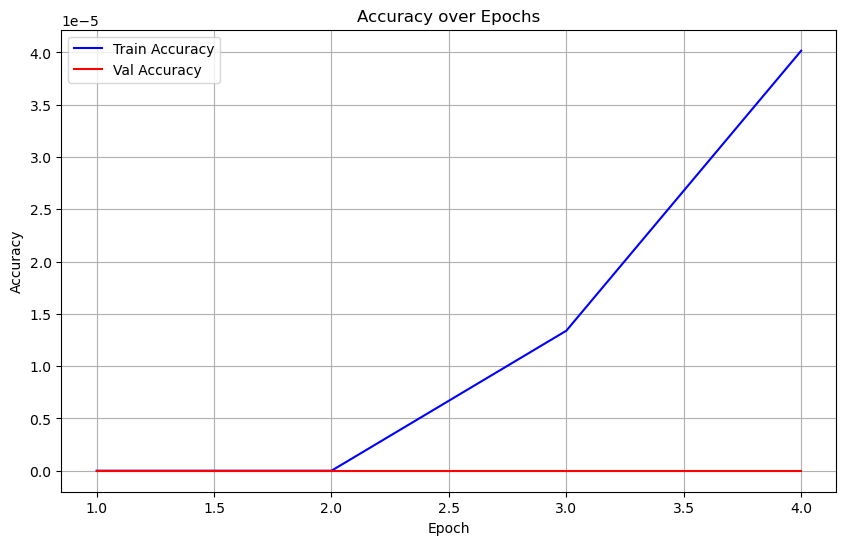

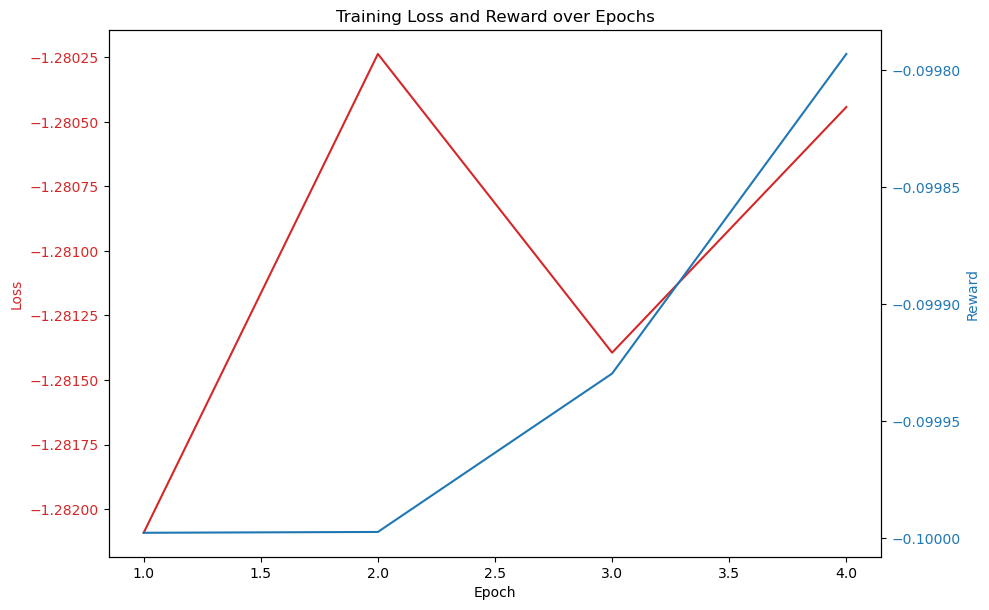

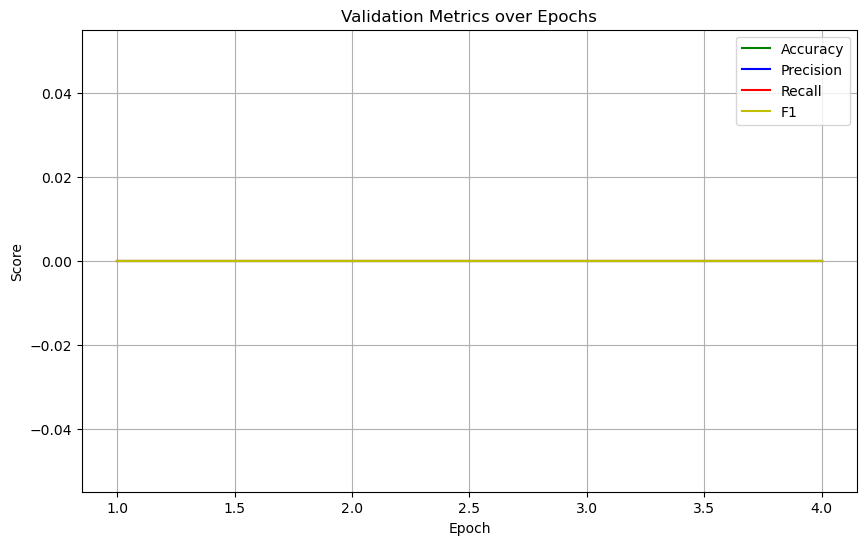

In [49]:
# Cell 18: Execution Block (Add CUDA_LAUNCH_BLOCKING info)
if __name__ == "__main__":
    logger.info(f"CUDA_LAUNCH_BLOCKING is set to: {os.environ.get('CUDA_LAUNCH_BLOCKING', 'Not Set')}")
    try:
        # ... (wandb init optional) ...
        teacher_model, student_model, metrics_history, final_metrics = main()
        # ... (Log final results) ...
        logger.info("====================== Final Results ======================")
        if metrics_history:
             best_acc = max(m['val_accuracy'] for m in metrics_history if not np.isnan(m['val_accuracy'])) if any(not np.isnan(m['val_accuracy']) for m in metrics_history) else float('nan')
             logger.info(f"Best Validation Accuracy Achieved: {best_acc:.4f}")
        logger.info(f"Final Metrics (using best model):")
        for k, v in final_metrics.items():
             logger.info(f"  {k}: {v:.4f}")
        logger.info("===========================================================")

    except Exception as e:
        logger.error(f"An error occurred during the main execution: {e}", exc_info=True)
        # ... (wandb finish optional) ...



